# EX8 인물사진 만들기

- 2개 이상의 렌즈를 탑재해야 '인물사진모드' 가 지원(배경과 인물을 각각 촬영 후 합성)
- DSLR에서는 피사계 심도(DOF)를 얕게 해서 초점이 맞은 피사체를 제외한 배경을 흐리게 만듦.
- '아웃포커싱'(얕은 피사계 심도, 셸로우 포커스) : 배경을 흐리게 하는 기술

*********************
### 1) 사진 준비
### 2) 세그멘테이션으로 사람 분리하기
### 3) 시맨틱 세그멘테이션 다뤄보기
### 4) 세그멘테이션 결과를 원래 크기로 복원하기
### 5) 배경 흐리게 하기
### 6) 흐린 배경과 원본 영상 합성

In [11]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

- 경로 설정 및 사진 불러오기

In [12]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/self2.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(960, 720, 3)


- 이미지 세그멘테이션(픽셀 단위로 관심객체를 추출하는 방법)
- 시맨틱 세그멘테이션 : 물리적 의미 단위로 인식하는 세그멘테이션
- 인스턴스 세그멘테이션 : 사람 개개인별로 다른 라벨을 가시게 함(각 개체를 분할해서 인식)

In [13]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수
- input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리

In [14]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


- 준비한 이미지를 네트워크에 입력

In [15]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(960, 720, 3) (513, 384, 3) 15


In [16]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 세그멘테이션 결과

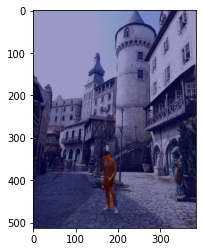

In [17]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

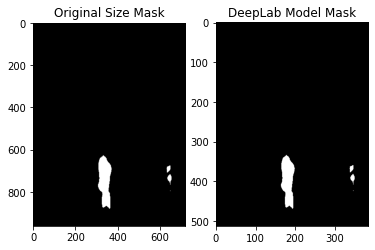

In [18]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

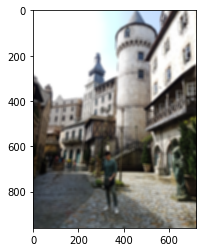

In [19]:
# 배경을 흐리게 만들기.
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

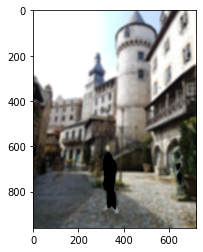

In [20]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
# bitwise_not 함수를 이용하면 이미지가 반전 배경은 255, 사람은 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

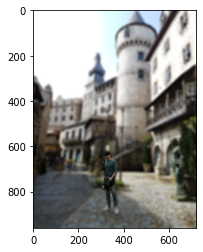

In [21]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

********************
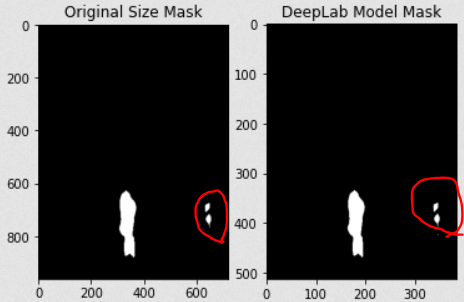

***문제점***
- 인물을 세그멘테이션 할때 오른쪽 동상에도 인물로 잡혔다.
- 세그멘테이션 할때는 사람 전체가 잡혔지만, 배경과 합성할때는 다리도 흐릿하게 나왔다.
- 완전 멀리 있는 인물은 잡아내지 못했다.

************
### 과연 게임 속 인물도 사람으로 인식할까

In [33]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/gta.PNG'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(895, 1590, 3)


In [23]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [24]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [25]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(895, 1590, 3) (288, 513, 3) 15


In [26]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

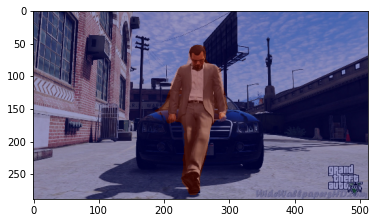

In [27]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

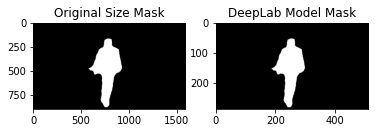

In [28]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

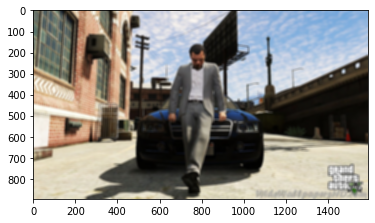

In [29]:
# 배경을 흐리게 만들기.
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

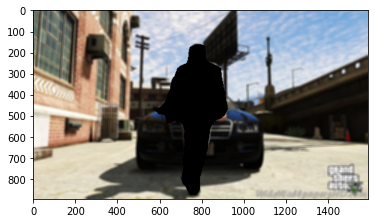

In [30]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
# bitwise_not 함수를 이용하면 이미지가 반전 배경은 255, 사람은 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

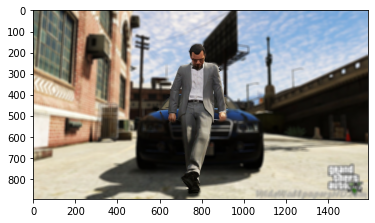

In [31]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

***문제점***
- 게임 사진도 세그멘테이션을 잘 찾지만, 아쉬운건 오른쪽 손의 끝부분까지는 잡아내지 못했다.
**********************

In [34]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/self.jpg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2592, 1944, 3)


In [35]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [36]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [37]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2592, 1944, 3) (513, 384, 3) 15


In [38]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

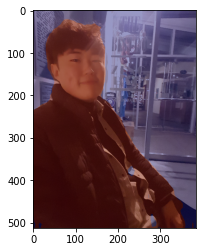

In [39]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

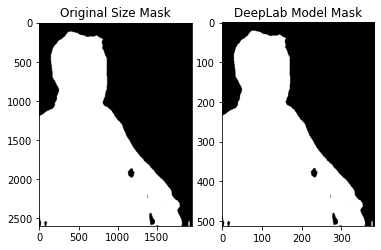

In [40]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

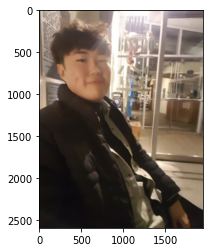

In [41]:
# 배경을 흐리게 만들기.
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

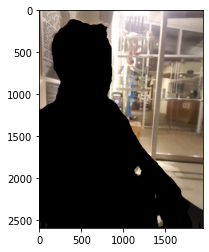

In [42]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
# bitwise_not 함수를 이용하면 이미지가 반전 배경은 255, 사람은 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

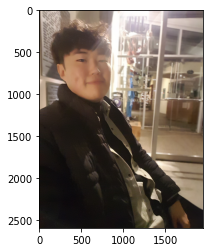

In [43]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

***문제점***
- 팔이 완전하게 인식을 못했다.
- 흐림의 정도를 나타낼 수 있을까??
- 사진 자체가 흐려서 정확히 구분을 하지 못했다.
- 인물을 잘랐을때 작은 부분을 인식 못했다.

****************
### 크로마키 배경 합성

In [44]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/game1.jpg'
img_orig = cv2.imread(img_path3) 
print (img_orig.shape)

(1136, 1136, 3)


(1136, 1136, 3) (513, 513, 3) 15


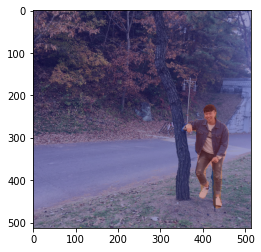

In [46]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
# 사람 추출 label은 15
img_mask = seg_map * (255/seg_map.max())
# 255 normalization(이미지 정규화)
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

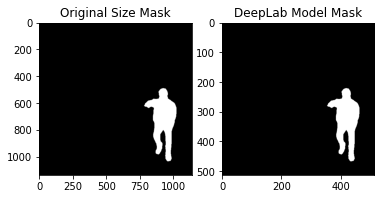

In [47]:
# (4) 세그멘테이션 결과를 원래 크기로 복원하기
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

(1136, 1136, 3)


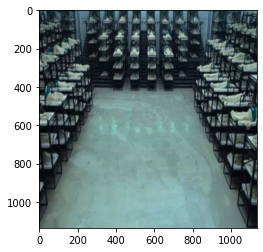

In [48]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/game.PNG'
img_bg = cv2.imread(img_path4)
img_bg = MODEL.preprocess(img_bg)
img_bg = cv2.resize(img_bg,img_mask_up.shape)
print(img_bg.shape)
plt.imshow(img_bg)

In [49]:
target_size = (img_orig.shape[1], img_orig.shape[0])
print("변경하려는 사이즈: ", target_size)
bg_resize = cv2.resize(img_bg, target_size)
print("배경 변경한 사이즈: ", bg_resize.shape)

변경하려는 사이즈:  (1136, 1136)
배경 변경한 사이즈:  (1136, 1136, 3)


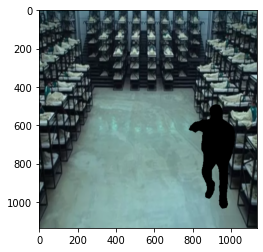

In [50]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_masked = cv2.bitwise_and(bg_resize, img_bg_mask)
plt.imshow(img_bg_masked)
plt.show()

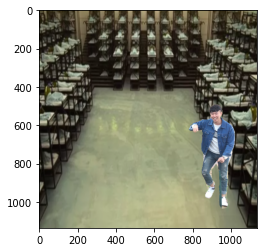

In [51]:
# 배경과 원본 합성
# 255인 부분만 원본을 가져온 후 나머지는 blur 이미지
img_concat = np.where(img_mask_color==255, img_orig, bg_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

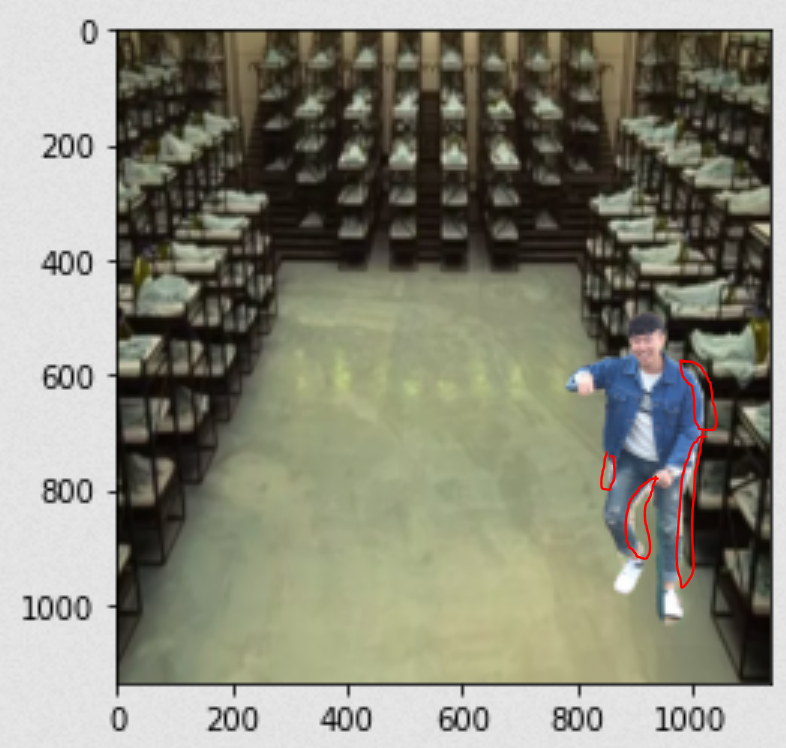

***문제점***
- 크로마키로 배경을 바꾸는 데에는 성공했지만 인물을 추출하는데 정확한 구분을 하지 못해서 어색하다.
- 이미지 리사이즈를 꼭 해줘서 타켓과 원본의 사이즈가 같아야 합쳐진다.
*********************

In [56]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/game1.jpg'
img_orig = cv2.imread(img_path3) 
print (img_orig.shape)

(1136, 1136, 3)


(1136, 1136, 3) (513, 513, 3) 15


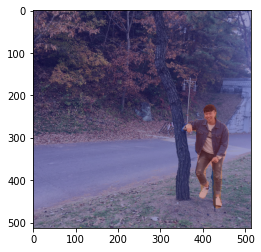

In [57]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
# 사람 추출 label은 15
img_mask = seg_map * (255/seg_map.max())
# 255 normalization(이미지 정규화)
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

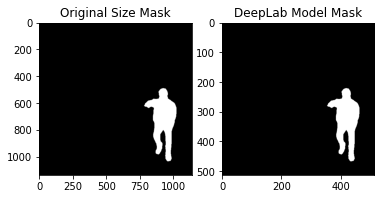

In [58]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

(1136, 1136, 3)


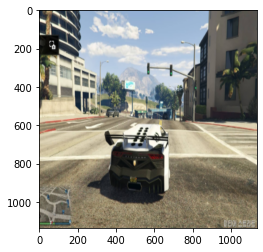

In [60]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/gta2.PNG'
img_bg = cv2.imread(img_path4)
img_bg = MODEL.preprocess(img_bg)
img_bg = cv2.resize(img_bg,img_mask_up.shape)
print(img_bg.shape)
plt.imshow(img_bg)

In [61]:
target_size = (img_orig.shape[1], img_orig.shape[0])
print("변경하려는 사이즈: ", target_size)
bg_resize = cv2.resize(img_bg, target_size)
print("배경 변경한 사이즈: ", bg_resize.shape)

변경하려는 사이즈:  (1136, 1136)
배경 변경한 사이즈:  (1136, 1136, 3)


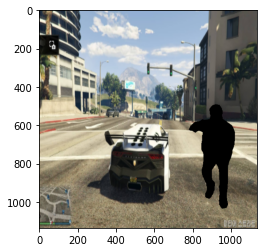

In [62]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_masked = cv2.bitwise_and(bg_resize, img_bg_mask)
plt.imshow(img_bg_masked)
plt.show()

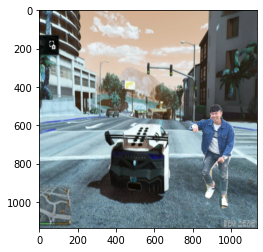

In [63]:
img_concat = np.where(img_mask_color==255, img_orig, bg_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

***************

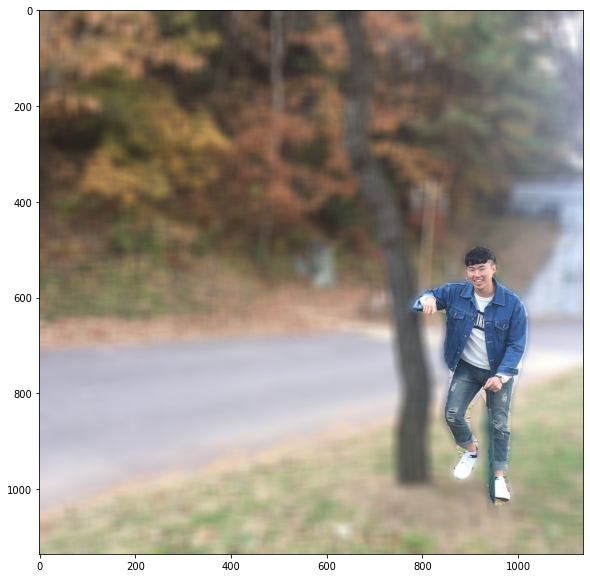

In [80]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/game1.jpg' 
img_orig = cv2.imread(img_path)

img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) 
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (25,25))

# 이미지에서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.figure(figsize=(10, 10))

img_concat3 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

***위에서 했던 결과를 가우시안 Blur 처리로 깔끔하게 표현해보기***

In [85]:
# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지 가우시안 Blur 처리
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지 가우시안 Blur 처리
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

image_blur = img_Gmask*img_orig.astype(np.float32)

# 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output = (image_blur+img_bg_mask).astype(np.uint8)

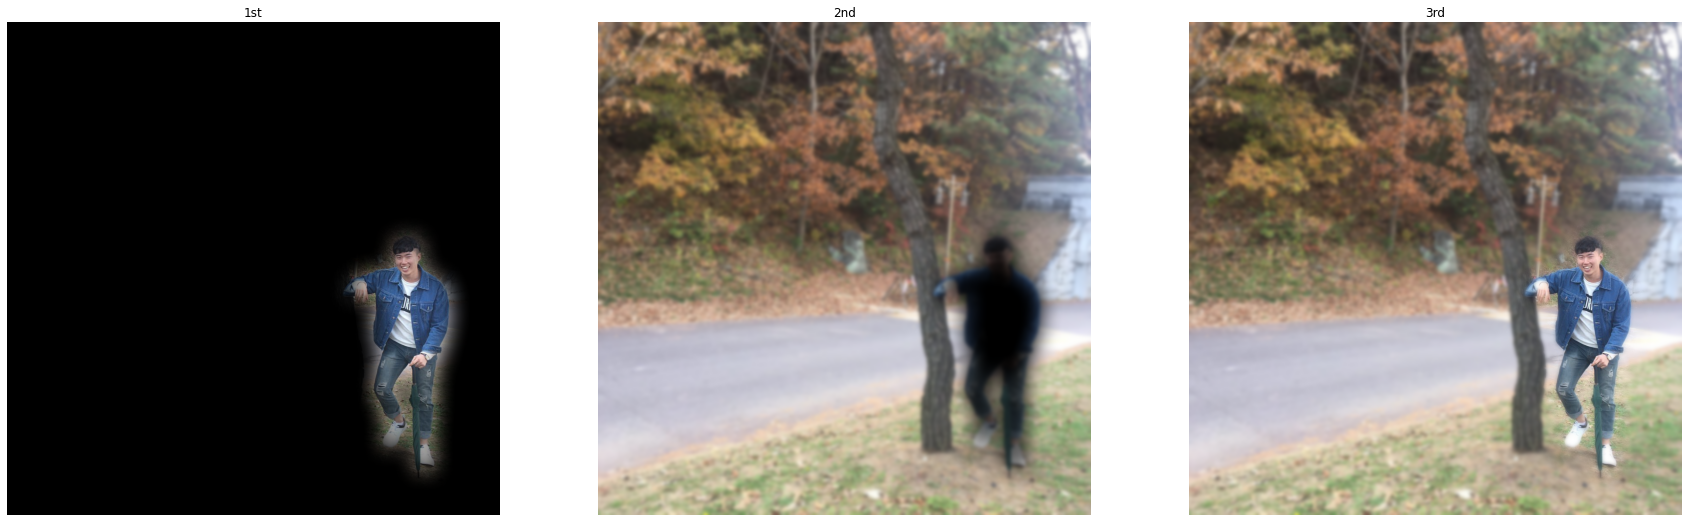

In [86]:
# GaussianBlur 처리한 부분을 확인하기
fig = plt.figure(figsize=(30, 20)) 

ax = plt.subplot(131)
plt.imshow(cv2.cvtColor(image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('1st')
plt.axis('off')
ax = plt.subplot(132)
plt.imshow(cv2.cvtColor(img_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('2nd')
plt.axis('off')
ax = plt.subplot(133)
plt.imshow(cv2.cvtColor(img_output,cv2.COLOR_BGR2RGB))
plt.title('3rd')
plt.axis('off')
plt.show()

- 좀 더 경계부분이 자연스럽게 나온것을 확인할 수 있었다.

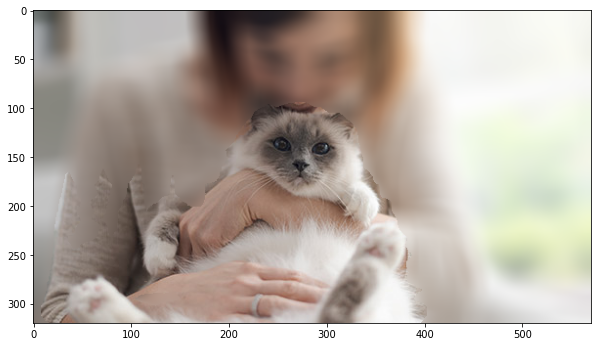

In [88]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg' 
img_orig = cv2.imread(img_path)


img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) 
img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)


img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (25,25))

# 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.figure(figsize=(10, 10))

img_concat3 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

In [89]:
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)

img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)


image_blur = img_Gmask*img_orig.astype(np.float32)

img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output = (image_blur+img_bg_mask).astype(np.uint8)

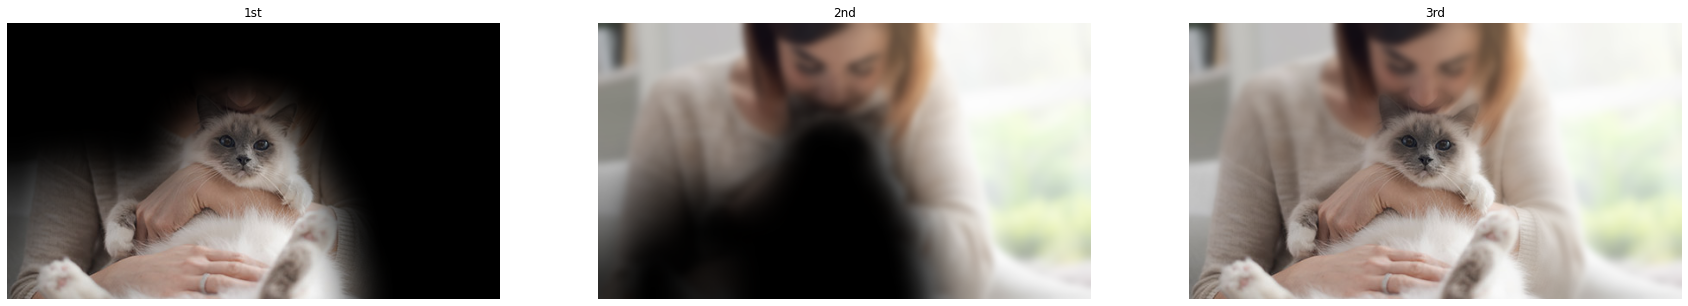

In [90]:
fig = plt.figure(figsize=(30, 20)) 

ax = plt.subplot(131)
plt.imshow(cv2.cvtColor(image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('1st')
plt.axis('off')
ax = plt.subplot(132)
plt.imshow(cv2.cvtColor(img_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('2nd')
plt.axis('off')
ax = plt.subplot(133)
plt.imshow(cv2.cvtColor(img_output,cv2.COLOR_BGR2RGB))
plt.title('3rd')
plt.axis('off')
plt.show()

********************
# 회고

- 오류
1. **사람**과 **배경**의 구분이 정확하지 않다.
2. 사람과 **가까이 있는 사물**이나 **잡고 있는 사물**은 배경으로 인식이 잘 안된다.
*****************

- 해결 방안

1) 기계학습으로 사람과 배경을 구분한다.

2) 깊이를 알기위해 PDAF픽셀이라는 기술을 사용한다.(깊이 맵을 생성 후 고해상도로 보간한다.)

3) 어두운 환경의 이미지는 높은 노이즈로 부정확하다.

4) 사람과 배경 분할 마스크를 깊이 맵과 결합하여 사진의 각 픽셀을 조정하고 모두 합친다.

***********
- 느낀점과 앞으로의 방향

***지정된 사물이나 인물을 정확하게는 아니지만, 대략적으로 인식하고 추출하는 것이 신기했고, 수학이 더더욱 중요한 것을 깨닫게 되었습니다.***

**사람이 인식하는 방법과, 기계가 픽셀별로 인식하는 방법이 다른 부분이 굉장히 재밌습니다.**

***사실상 지식을 아는 것보다 어떻게 활용할 수 있느냐가 중요한 것인데, 현재 찾아보기만 한다면 모든 지식과 노하우들을 인터넷을 통해 배울 수가 있기 때문에 더 많은 시간이 필요할 것 같습니다.***

***3D Depth Camera를 이용해서 깊이에 대한 정보를 알아낼수가 있다는데, 다음에 한번 더 도전해보려고 합니다.***

***다른 사람들의 코드를 찾아보고 변수들을 바꿔가며 적용하는데 시간이 오래 걸리지만, 이것 또한 공부가 되는것 같습니다.***